In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow

from esem import gp_model
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

2024-03-05 01:00:23.027402: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 01:00:23.027482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 01:00:23.028478: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 01:00:23.034760: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 01:01:45.047752: W tensorflow/compiler/tf2

### Prepare data

In [2]:
# List of dataset to use for training
train_files = ["ssp126", "ssp370", "ssp585", "historical", "hist-GHG"]

In [3]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(train_files)
y_train_pr = create_predictdand_data(train_files)['pr'].values.reshape(-1, 96 * 144)

X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
pr_truth = Y_test["pr"].mean('member')

In [4]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_pr = y_train_pr[~nan_train_mask]
assert len(X_train) == len(y_train_pr)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
pr_truth = pr_truth[~nan_test_mask]

In [5]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [6]:
# Standardize predictand fields
train_pr_mean, train_pr_std = y_train_pr.mean(), y_train_pr.std()
y_train_pr = (y_train_pr - train_pr_mean) / train_pr_std

# Scale pr
pr_truth *= 86400

### Prepare model

In [7]:
import gpflow
from gpflow.utilities import to_default_float
from gpflow.optimizers import Scipy
from gpflow.mean_functions import Constant
from gpflow.kernels import Matern52
from gpflow.utilities import print_summary

In [8]:
def create_feature_extractor(input_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='linear'),
        tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float64))
    ])
    return model


In [9]:
class DeepKernel(gpflow.kernels.Kernel):
    def __init__(self, feature_extractor, base_kernel, input_dim):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.base_kernel = base_kernel
        self.input_dim = input_dim

    def K(self, X, X2=None):
        # Transform X and X2 using the neural network
        X_transformed = self.feature_extractor(X)
        X2_transformed = self.feature_extractor(X2) if X2 is not None else X2
        # Compute the kernel using the transformed inputs
        return self.base_kernel(X_transformed, X2_transformed)

    def K_diag(self, X):
        X_transformed = self.feature_extractor(X)
        return self.base_kernel.K_diag(X_transformed)


In [10]:
# Define the neural network feature extractor
input_dim = X_train.shape[1]  # Number of features in X
output_dim = 24
feature_extractor = create_feature_extractor(input_dim, output_dim)

# Freeze the neural network layers to make them non-trainable in GPflow's optimization process
for layer in feature_extractor.layers:
    layer.trainable = True

# Define the base kernel and the deep kernel
kernel_CO2 = Matern52(active_dims=[0, 1], variance=1.0, lengthscales=2 * [1.])
kernel_CH4 = Matern52(active_dims=[2, 3], variance=1.0, lengthscales=2 * [1.])
kernel_BC = Matern52(active_dims=[4, 5, 6, 7, 8, 9, 10, 11, 12, 13], variance=1.0, lengthscales=10 * [1.])
kernel_SO2 = Matern52(active_dims=[14, 15, 16, 17, 18, 19, 20, 21, 22, 23], variance=1.0, lengthscales=10 * [1.])

kernel_matern12 = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

base_kernel = kernel_matern12
deep_kernel = DeepKernel(feature_extractor=feature_extractor, base_kernel=base_kernel, input_dim=input_dim)

# Mean Function
mean_function = Constant()

# Create the GP model
model = gpflow.models.GPR(data=(X_train.astype(float), y_train_pr.astype(float)), kernel=deep_kernel, mean_function=mean_function)

# Compile the TensorFlow model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def optimization_step():
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        loss = -model.log_marginal_likelihood()
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

2024-03-05 01:06:26.949337: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79084 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [11]:
tolerance = 1e-6  # Define tolerance
patience = 10  # Define patience

# Initialize variables for early stopping mechanism
best_loss = float('inf')
patience_counter = 0
max_iterations = 5000

# Training loop
for iteration in range(max_iterations):  # Number of optimization steps
    loss = optimization_step()

    # Early stopping logic
    if best_loss - loss < tolerance:
        patience_counter += 1
    else:
        patience_counter = 0
        best_loss = loss

    if patience_counter >= patience:
        print(f"Stopping training after {iteration + 1} iterations due to convergence.")
        break

2024-03-05 01:06:35.016198: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0xb7047e0
2024-03-05 01:06:35.109395: I external/local_xla/xla/service/service.cc:168] XLA service 0x150ceae3c5f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-05 01:06:35.109444: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-03-05 01:06:35.114402: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-05 01:06:35.142153: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1709625995.236145  171163 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Stopping training after 118 iterations due to convergence.


### Predict on testing set

In [12]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_pr_std + train_pr_mean
posterior_std = np.sqrt(standard_posterior_var) * train_pr_std

In [13]:
# put output back into xarray format for calculating RMSE/plotting
posterior_pr = np.reshape(posterior_mean, [86, 96, 144])
posterior_pr_std = np.reshape(posterior_std, [86, 96, 144])

posterior_pr_data = xr.DataArray(posterior_pr, dims=pr_truth.dims, coords=pr_truth.coords)
posterior_pr_std_data = xr.DataArray(posterior_pr_std, dims=pr_truth.dims, coords=pr_truth.coords)

In [14]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(pr_truth[35], posterior_pr_data[35])}")
print(f"RMSE at 2100: {get_rmse(pr_truth[85], posterior_pr_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(pr_truth[30:41], posterior_pr_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr_truth[75:], posterior_pr_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr_truth[35:], posterior_pr_data[35:]).mean()}")

RMSE at 2050: 0.3954335241174067
RMSE at 2100: 1.2920988574328611
RMSE 2045-2055: 0.49119060574659756
RMSE 2090-2100: 1.1013298026102154
RMSE 2050-2100: 0.7859766717882357


[Text(0.5, 1.0, 'Difference')]

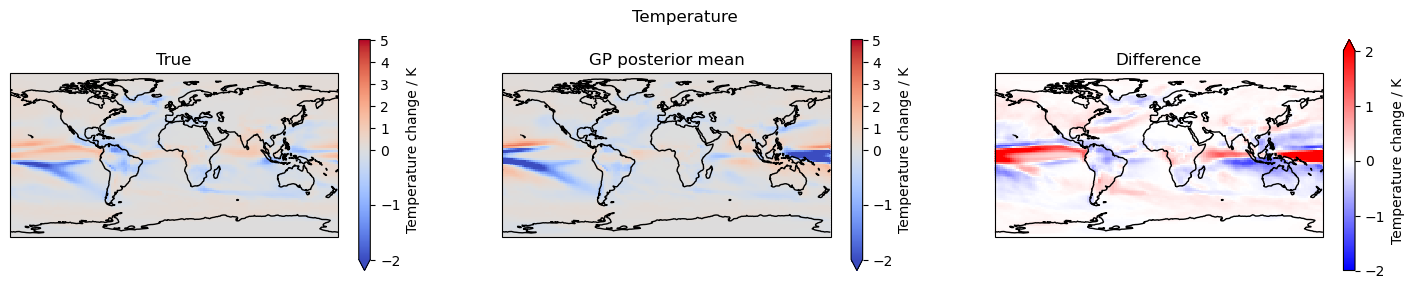

In [15]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
pr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_pr_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = pr_truth - posterior_pr_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [16]:
def global_mean(ds):
    if 'lat' not in ds.coords:
        ds_ = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    else:
        ds_ = ds
    weights = np.cos(np.deg2rad(ds_.lat))
    return ds_.weighted(weights).mean(['lat', 'lon'])

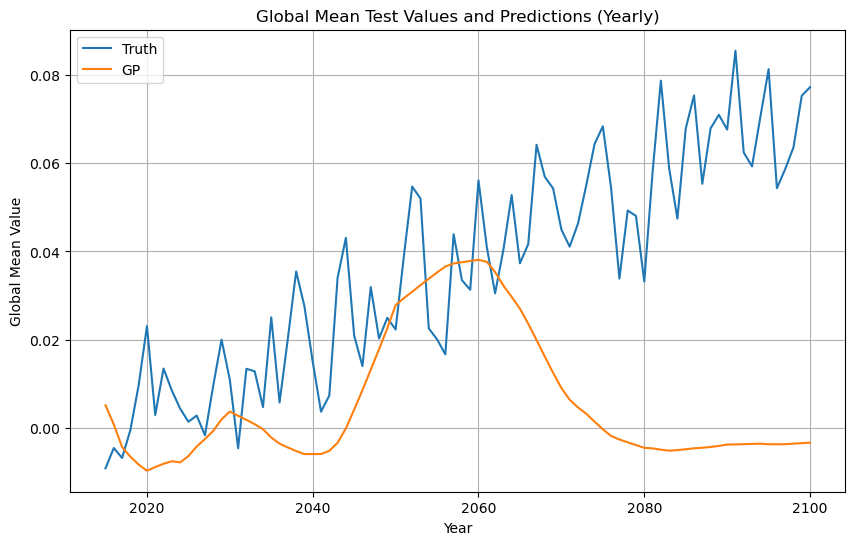

In [17]:
# t = xr.open_dataarray('climatebench-gp-posterior-mean-pr-test-2019-2100.nc')
plt.figure(figsize=(10, 6))
global_mean(pr_truth).plot(label="Truth")
global_mean(posterior_pr_data).plot(label='GP')
# global_mean(t).plot(label='from repo')
plt.title('Global Mean Test Values and Predictions (Yearly)')
plt.ylabel('Global Mean Value')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

## Hyperparams Tuning

In [18]:
from ray import tune, train
from ray.tune.search.hyperopt import HyperOptSearch
from gpflow.kernels import Matern12, Matern32, Matern52, SquaredExponential, RationalQuadratic, Cosine, Periodic, Polynomial, ArcCosine, Exponential
import keras
import math
from gpflow.mean_functions import Constant
from xskillscore import rmse
from ray.tune import CLIReporter
import ray

In [19]:
ray.init(num_cpus=1, num_gpus=1)

2024-03-05 01:07:21,181	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.9.18
Ray version:,2.9.3


In [20]:
def get_rmse(truth, pred):
    return np.sqrt(((truth-pred)**2))

def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).mean(['lat', 'lon'])

def global_sum(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).sum(['lat', 'lon'])

weights = np.cos(np.deg2rad(pr_truth.lat)).expand_dims(lon=144).assign_coords(lon=pr_truth.lon)
    
def TNRMSE(truth, pred, Yearslice=slice(2080, None)):
    # R2E Score
    R2E = rmse(
        global_mean(truth.sel(time=Yearslice)), 
        global_mean(pred.sel(time=Yearslice))
    ).data/np.abs(global_mean(truth.sel(time=Yearslice).mean('time')).data)

    # NRMSE score
    NRMSE = rmse(
        truth.sel(time=Yearslice).mean('time'), 
        pred.sel(time=Yearslice).mean('time'), weights=weights
    ).data/ np.abs(global_mean(truth.sel(time=Yearslice).mean('time')).data)

    total = (NRMSE + 5*R2E).T.round(3)
    return total

In [21]:
def make_feature_extractor(dim_max, activation, input_dim, output_dim, dropout_prob, bnorm=True, dropout=True):
    model = tf.keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(input_dim,)))
    
    dimensions = [dim_max // (2 ** i) for i in range(int(math.log(dim_max, 2)) + 1) if dim_max // (2 ** i) > input_dim]

    for dim in dimensions[::-1]:
        model.add(keras.layers.Dense(dim, activation=activation))
        if bnorm:
            model.add(keras.layers.BatchNormalization())
        if dropout:
            model.add(keras.layers.Dropout(dropout_prob))

    for dim in dimensions:
        if dim <= output_dim:
            break
        model.add(keras.layers.Dense(dim, activation=activation))
        if bnorm:
            model.add(keras.layers.BatchNormalization())
        if dropout:
            model.add(keras.layers.Dropout(dropout_prob))

    model.add(keras.layers.Dense(output_dim, activation='linear'))
    model.add(keras.layers.Lambda(lambda x: tf.cast(x, tf.float64)))
        
    return model

In [22]:
def basekernel(kernel_types, active_dim_multiplier, variance=1.0, lengthscales=1.0):
    kernels = {
        'Matern12': Matern12, 'Matern32': Matern32, 'Matern52': Matern52, 'SquaredExponential': SquaredExponential, 'RationalQuadratic': RationalQuadratic, 'Cosine':Cosine, 'Periodic': Periodic,
        'Polynomial': Polynomial, 'ArcCosine': ArcCosine, 'Exponential': Exponential
    }
    dims = [x for x in range(12*active_dim_multiplier)]
    def CO2(kernel):
        active_dims = dims[0:active_dim_multiplier*1]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(1*active_dim_multiplier) * [1.])
        return k

    def CH4(kernel):
        active_dims = dims[1*active_dim_multiplier:active_dim_multiplier*2]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(1*active_dim_multiplier) * [1.])
        return k
        
    def BC(kernel):
        active_dims = dims[2*active_dim_multiplier:active_dim_multiplier*2 + 5*active_dim_multiplier]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(5*active_dim_multiplier) * [1.])
        return k

    def SO2(kernel):
        active_dims = dims[active_dim_multiplier*2 + 5*active_dim_multiplier:]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(5*active_dim_multiplier) * [1.])
        return k
    
    kernel = CO2(kernels[kernel_types[0]]) + CH4(kernels[kernel_types[1]]) + BC(kernels[kernel_types[2]]) + SO2(kernels[kernel_types[3]])

    return kernel

In [23]:
def objective(config, return_pred=False):  # ①
    input_dim = X_train.shape[1]  # Number of features in X
    
    output_dim = config["output_dim"]
    # Feature extractor for deep kernel
    feature_extractor = make_feature_extractor(
        config["dim_max"], config["activation"], input_dim, config["output_dim"], config["dropout_prob"], bnorm=config["bnorm"], dropout=config["dropout"]
    )
    
    # Freeze the neural network layers to make them non-trainable in GPflow's optimization process
    for layer in feature_extractor.layers:
        layer.trainable = True
    
    # Define kernel
    base_kernel = basekernel(
        config["kernel_types"], config["active_dim_multiplier"]
    )
    deep_kernel = DeepKernel(feature_extractor=feature_extractor, base_kernel=base_kernel, input_dim=input_dim)

    mean_function = Constant() # Define Mean function

    optimizer  = tf.keras.optimizers.Adam(learning_rate=config["optimizer_lr"])# Define opt

    model = gpflow.models.GPR(data=(X_train.astype(float), y_train_pr.astype(float)), kernel=deep_kernel, mean_function=mean_function)
    

    # custom optimizer
    @tf.function
    def optimization_step():
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(model.trainable_variables)
            loss = -model.log_marginal_likelihood()
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss


    # Training
    tolerance, patience = 1e-6, 10  # Define tolerance and patience

    # Initialize variables for early stopping mechanism
    best_loss, patience_counter, max_iterations = float('inf'), 0, 5000
    
    # Training loop
    for iteration in range(max_iterations):  # Number of optimization steps
        loss = optimization_step()
    
        # Early stopping logic
        if best_loss - loss < tolerance:
            patience_counter += 1
        else:
            patience_counter = 0
            best_loss = loss
    
        if patience_counter >= patience:
            print(f"Stopping training after {iteration + 1} iterations due to convergence.")
            break

    # Eval
    standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
    posterior_mean = standard_posterior_mean * train_pr_std + train_pr_mean
    posterior_std = np.sqrt(standard_posterior_var) * train_pr_std

    # put output back into xarray format for calculating RMSE/plotting
    posterior_pr = np.reshape(posterior_mean, [86, 96, 144])
    posterior_pr_std = np.reshape(posterior_std, [86, 96, 144])
    
    posterior_pr_data = xr.DataArray(posterior_pr, dims=pr_truth.dims, coords=pr_truth.coords)
    posterior_pr_std_data = xr.DataArray(posterior_pr_std, dims=pr_truth.dims, coords=pr_truth.coords)

    total_NRMSE = TNRMSE(pr_truth, posterior_pr_data)

    if return_pred:
        return posterior_pr_data, posterior_pr_std_data


    return {'nrmse':total_NRMSE}

In [24]:
def run_tuner(search_space, num_samples=50):
    algo = HyperOptSearch()
    
    tuner = tune.Tuner(  # ③
        tune.with_resources(
            objective,
            resources={"cpu": 1, "gpu": 1}
        ),
        tune_config=tune.TuneConfig(
            metric="nrmse",
            mode="min",
            num_samples=num_samples,
            search_alg=algo,
        ),
        param_space=search_space,
    )

    results = tuner.fit()
    return results

In [25]:
search_space_2 = {
        "activation": tune.choice(["relu", "tanh", 'sigmoid']), "bnorm": tune.choice([True, False]), "dropout": tune.choice([True, False]), 'dropout_prob': tune.choice([0.5]),
        "kernel_types": tune.choice([4*['Matern32'], 4*['Matern12'], 4*['Matern52']]), "active_dim_multiplier": tune.choice([1, 2]), "dim_max": tune.choice([128, 256, 512]), 
        "output_dim": tune.choice([36, 48, 60, 72, 84]), "optimizer_lr": tune.choice([0.01, 0.001, 0.0001])
    }  # ②

search_space_1 = {
    "activation": tune.choice(["relu", "tanh", 'sigmoid']), "bnorm": tune.choice([True, False]), "dropout": tune.choice([True, False]), 'dropout_prob': tune.choice([0.5]),
    "kernel_types": tune.choice([4*['Matern32'], 4*['Matern12'], 4*['Matern52'], 4*['SquaredExponential']]), "active_dim_multiplier": tune.choice([1, 2]), "dim_max": tune.choice([128, 256, 64]), 
    "output_dim": tune.choice([12, 24, 36, 48, 60]), "optimizer_lr": tune.choice([0.01, 0.001])
} 

result = run_tuner(search_space_1)

(raylet) Warning: The actor ImplicitFunc is very large (35 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(pid=172160) 2024-03-05 01:08:24.246113: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=172160) 2024-03-05 01:08:24.246233: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=172160) 2024-03-05 01:08:24.247243: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=172160) 2024-03-05 01:08:24.252781: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=172160) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

(objective pid=172160) Stopping training after 215 iterations due to convergence.


(objective pid=172160) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15179722d430> and will run it as-is.
(objective pid=172160) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=172160) Cause: Unknown node type <gast.gast.Import object at 0x151636fae8b0>
(objective pid=172160) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:08:44,574	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=172160) Stopping training after 103 iterations due to convergence.


(objective pid=172160) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1517964c7a60> and will run it as-is.
(objective pid=172160) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=172160) Cause: Unknown node type <gast.gast.Import object at 0x1516140784f0>
(objective pid=172160) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=172160) Stopping training after 114 iterations due to convergence.


2024-03-05 01:09:00,753	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 11.098 s, which may be a performance bottleneck.
2024-03-05 01:09:00,756	WARNING util.py:202 -- The `process_trial_result` operation took 11.101 s, which may be a performance bottleneck.
2024-03-05 01:09:00,757	WARNING util.py:202 -- Processing trial results took 11.102 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-03-05 01:09:00,759	WARNING util.py:202 -- The `process_trial_result` operation took 11.105 s, which may be a performance bottleneck.
2024-03-05 01:09:00,983	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
(objective pid=172160) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x151636f5b8b0> and will run it as-is.

(objective pid=172160) Stopping training after 187 iterations due to convergence.


2024-03-05 01:09:09,368	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
(objective pid=172160) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1516704bc3a0> and will run it as-is.
(objective pid=172160) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=172160) Cause: Unknown node type <gast.gast.Import object at 0x151636fc7160>
(objective pid=172160) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:09:23,351	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=172160) Stopping training after 1142 iterations due to convergence.


(objective pid=172160) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1517964c7b80> and will run it as-is.
(objective pid=172160) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=172160) Cause: Unknown node type <gast.gast.Import object at 0x15158d930310>
(objective pid=172160) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:09:30,810	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=172160) Stopping training after 89 iterations due to convergence.


(objective pid=172160) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15158df4e1f0> and will run it as-is.
(objective pid=172160) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=172160) Cause: Unknown node type <gast.gast.Import object at 0x15158d6e2dc0>
(objective pid=172160) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:09:44,508	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=172160) Stopping training after 1153 iterations due to convergence.


(objective pid=172160) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15158d8193a0> and will run it as-is.
(objective pid=172160) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=172160) Cause: Unknown node type <gast.gast.Import object at 0x15158ce5f2b0>
(objective pid=172160) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=172160) 2024-03-05 01:09:56.781981: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 108.0KiB (rounded to 110592)requested by op Sum_4
(objective pid=172160) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=172160) Current allocation summary follows.
(objective pid

(objective pid=173116) Stopping training after 235 iterations due to convergence.


(objective pid=173116) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146d19fce0d0> and will run it as-is.
(objective pid=173116) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=173116) Cause: Unknown node type <gast.gast.Import object at 0x146d10045850>
(objective pid=173116) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:10:30,831	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=173116) Stopping training after 72 iterations due to convergence.


(objective pid=173116) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146d19fce0d0> and will run it as-is.
(objective pid=173116) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=173116) Cause: Unknown node type <gast.gast.Import object at 0x146cba84a070>
(objective pid=173116) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:10:39,860	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=173116) Stopping training after 256 iterations due to convergence.


(objective pid=173116) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146cd289f430> and will run it as-is.
(objective pid=173116) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=173116) Cause: Unknown node type <gast.gast.Import object at 0x146cba67dc70>
(objective pid=173116) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:10:54,624	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=173116) Stopping training after 1051 iterations due to convergence.


(objective pid=173116) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146cba39cee0> and will run it as-is.
(objective pid=173116) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=173116) Cause: Unknown node type <gast.gast.Import object at 0x146cb9aed1c0>
(objective pid=173116) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:11:00,303	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=173116) Stopping training after 106 iterations due to convergence.


(objective pid=173116) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146cb9777040> and will run it as-is.
(objective pid=173116) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=173116) Cause: Unknown node type <gast.gast.Import object at 0x146cb9540b50>
(objective pid=173116) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:11:09,218	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=173116) Stopping training after 105 iterations due to convergence.


(objective pid=173116) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146cb9c61ee0> and will run it as-is.
(objective pid=173116) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=173116) Cause: Unknown node type <gast.gast.Import object at 0x146cb8d6dca0>
(objective pid=173116) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:11:15,587	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=173116) Stopping training after 175 iterations due to convergence.


(objective pid=173116) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146cb9777040> and will run it as-is.
(objective pid=173116) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=173116) Cause: Unknown node type <gast.gast.Import object at 0x146cb951fa30>
(objective pid=173116) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:11:20,128	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=173116) Stopping training after 49 iterations due to convergence.


(objective pid=173116) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146cb88d61f0> and will run it as-is.
(objective pid=173116) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=173116) Cause: Unknown node type <gast.gast.Import object at 0x146cb81d2550>
(objective pid=173116) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=173116) 2024-03-05 01:11:39.631887: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 62.02MiB (rounded to 65028096)requested by op gradient_tape/Mul_1
(objective pid=173116) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=173116) Current allocation summary follows

(objective pid=174064) Stopping training after 74 iterations due to convergence.


(objective pid=174064) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14c8cffb93a0> and will run it as-is.
(objective pid=174064) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=174064) Cause: Unknown node type <gast.gast.Import object at 0x14c748089fd0>
(objective pid=174064) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:12:15,539	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=174064) Stopping training after 57 iterations due to convergence.


(objective pid=174064) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14c7480e4b80> and will run it as-is.
(objective pid=174064) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=174064) Cause: Unknown node type <gast.gast.Import object at 0x14c7412b6970>
(objective pid=174064) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:12:21,885	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=174064) Stopping training after 108 iterations due to convergence.


(objective pid=174064) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14c741396dc0> and will run it as-is.
(objective pid=174064) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=174064) Cause: Unknown node type <gast.gast.Import object at 0x14c74072d460>
(objective pid=174064) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:12:27,782	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=174064) Stopping training after 165 iterations due to convergence.


(objective pid=174064) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14c740863ca0> and will run it as-is.
(objective pid=174064) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=174064) Cause: Unknown node type <gast.gast.Import object at 0x14c740580f10>
(objective pid=174064) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:12:43,518	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=174064) Stopping training after 1194 iterations due to convergence.


(objective pid=174064) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14c7413a6b80> and will run it as-is.
(objective pid=174064) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=174064) Cause: Unknown node type <gast.gast.Import object at 0x14c721dd3220>
(objective pid=174064) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:12:55,854	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=174064) Stopping training after 1018 iterations due to convergence.


(objective pid=174064) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14c74067a430> and will run it as-is.
(objective pid=174064) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=174064) Cause: Unknown node type <gast.gast.Import object at 0x14c72199b040>
(objective pid=174064) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:13:08,912	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=174064) Stopping training after 1106 iterations due to convergence.


(objective pid=174064) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14c721a0cee0> and will run it as-is.
(objective pid=174064) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=174064) Cause: Unknown node type <gast.gast.Import object at 0x14c74028ca90>
(objective pid=174064) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=174064) 2024-03-05 01:13:21.042281: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 108.0KiB (rounded to 110592)requested by op Sum_4
(objective pid=174064) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=174064) Current allocation summary follows.
(objective pid

(objective pid=174946) Stopping training after 587 iterations due to convergence.


(objective pid=174946) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14de9c13e430> and will run it as-is.
(objective pid=174946) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=174946) Cause: Unknown node type <gast.gast.Import object at 0x14dd5ffde9a0>
(objective pid=174946) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:14:05,499	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=174946) Stopping training after 1111 iterations due to convergence.


(objective pid=174946) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14de97455ee0> and will run it as-is.
(objective pid=174946) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=174946) Cause: Unknown node type <gast.gast.Import object at 0x14dd141ce7f0>
(objective pid=174946) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:14:17,686	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=174946) Stopping training after 806 iterations due to convergence.


(objective pid=174946) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14dd597f9af0> and will run it as-is.
(objective pid=174946) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=174946) Cause: Unknown node type <gast.gast.Import object at 0x14dced709460>
(objective pid=174946) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:14:30,859	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=174946) Stopping training after 873 iterations due to convergence.


(objective pid=174946) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14dd7428f820> and will run it as-is.
(objective pid=174946) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=174946) Cause: Unknown node type <gast.gast.Import object at 0x14dd597ac520>
(objective pid=174946) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:14:43,857	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=174946) Stopping training after 1098 iterations due to convergence.


(objective pid=174946) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14dd2c103040> and will run it as-is.
(objective pid=174946) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=174946) Cause: Unknown node type <gast.gast.Import object at 0x14dcec950c10>
(objective pid=174946) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:14:53,226	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=174946) Stopping training after 300 iterations due to convergence.


(objective pid=174946) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14dcecefd940> and will run it as-is.
(objective pid=174946) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=174946) Cause: Unknown node type <gast.gast.Import object at 0x14dcec9a5b80>
(objective pid=174946) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:14:59,139	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=174946) Stopping training after 221 iterations due to convergence.


(objective pid=174946) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14dcecb04550> and will run it as-is.
(objective pid=174946) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=174946) Cause: Unknown node type <gast.gast.Import object at 0x14dc91cab070>
(objective pid=174946) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=174946) 2024-03-05 01:15:12.056890: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 108.0KiB (rounded to 110592)requested by op Sum_4
(objective pid=174946) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=174946) Current allocation summary follows.
(objective pid

(objective pid=175839) Stopping training after 163 iterations due to convergence.


(objective pid=175839) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14eeb8979430> and will run it as-is.
(objective pid=175839) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=175839) Cause: Unknown node type <gast.gast.Import object at 0x14ed900d67c0>
(objective pid=175839) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=175839) Stopping training after 1027 iterations due to convergence.


2024-03-05 01:15:49,901	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
(objective pid=175839) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14ed900d9040> and will run it as-is.
(objective pid=175839) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=175839) Cause: Unknown node type <gast.gast.Import object at 0x14eeb89a3e50>
(objective pid=175839) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=175839) Stopping training after 1068 iterations due to convergence.


2024-03-05 01:16:04,654	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 1.888 s, which may be a performance bottleneck.
2024-03-05 01:16:04,657	WARNING util.py:202 -- The `process_trial_result` operation took 1.891 s, which may be a performance bottleneck.
2024-03-05 01:16:04,659	WARNING util.py:202 -- Processing trial results took 1.892 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-03-05 01:16:04,661	WARNING util.py:202 -- The `process_trial_result` operation took 1.894 s, which may be a performance bottleneck.
2024-03-05 01:16:04,665	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
(objective pid=175839) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14ed90df6d30> and will run it as-is.
(objective pid=175839) Please report this t

(objective pid=175839) Stopping training after 723 iterations due to convergence.


2024-03-05 01:16:18,643	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 1.803 s, which may be a performance bottleneck.
2024-03-05 01:16:18,646	WARNING util.py:202 -- The `process_trial_result` operation took 1.806 s, which may be a performance bottleneck.
2024-03-05 01:16:18,647	WARNING util.py:202 -- Processing trial results took 1.807 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-03-05 01:16:18,648	WARNING util.py:202 -- The `process_trial_result` operation took 1.808 s, which may be a performance bottleneck.
2024-03-05 01:16:18,651	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
(objective pid=175839) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14ed301b1b80> and will run it as-is.
(objective pid=175839) Please report this t

(objective pid=175839) Stopping training after 353 iterations due to convergence.


(objective pid=175839) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14eea4a96310> and will run it as-is.
(objective pid=175839) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=175839) Cause: Unknown node type <gast.gast.Import object at 0x14ed08f8b1f0>
(objective pid=175839) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:16:36,482	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=175839) Stopping training after 129 iterations due to convergence.


(objective pid=175839) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14ed091770d0> and will run it as-is.
(objective pid=175839) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=175839) Cause: Unknown node type <gast.gast.Import object at 0x14ed093467c0>
(objective pid=175839) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:16:42,246	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=175839) Stopping training after 224 iterations due to convergence.


(objective pid=175839) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14ed08aec670> and will run it as-is.
(objective pid=175839) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=175839) Cause: Unknown node type <gast.gast.Import object at 0x14ed083b3fa0>
(objective pid=175839) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=175839) 2024-03-05 01:16:56.993840: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 108.0KiB (rounded to 110592)requested by op Sum_4
(objective pid=175839) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=175839) Current allocation summary follows.
(objective pid

(objective pid=176737) Stopping training after 930 iterations due to convergence.


(objective pid=176737) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15153c01d940> and will run it as-is.
(objective pid=176737) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=176737) Cause: Unknown node type <gast.gast.Import object at 0x15141005c370>
(objective pid=176737) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:17:39,887	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=176737) Stopping training after 864 iterations due to convergence.


(objective pid=176737) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1515280845e0> and will run it as-is.
(objective pid=176737) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=176737) Cause: Unknown node type <gast.gast.Import object at 0x1514102b83d0>
(objective pid=176737) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:17:46,345	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=176737) Stopping training after 229 iterations due to convergence.


(objective pid=176737) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x151528084040> and will run it as-is.
(objective pid=176737) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=176737) Cause: Unknown node type <gast.gast.Import object at 0x15138d02aeb0>
(objective pid=176737) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:17:52,643	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=176737) Stopping training after 89 iterations due to convergence.


(objective pid=176737) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1515372a5ee0> and will run it as-is.
(objective pid=176737) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=176737) Cause: Unknown node type <gast.gast.Import object at 0x15138d1f39a0>
(objective pid=176737) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:18:04,963	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=176737) Stopping training after 1053 iterations due to convergence.


(objective pid=176737) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15138cfabee0> and will run it as-is.
(objective pid=176737) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=176737) Cause: Unknown node type <gast.gast.Import object at 0x15138c47ef70>
(objective pid=176737) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:18:18,770	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=176737) Stopping training after 269 iterations due to convergence.


(objective pid=176737) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15138cb77670> and will run it as-is.
(objective pid=176737) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=176737) Cause: Unknown node type <gast.gast.Import object at 0x151331e389d0>
(objective pid=176737) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=176737) Stopping training after 47 iterations due to convergence.


2024-03-05 01:18:25,055	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
(objective pid=176737) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15138cb77670> and will run it as-is.
(objective pid=176737) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=176737) Cause: Unknown node type <gast.gast.Import object at 0x1513317f7e20>
(objective pid=176737) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=176737) 2024-03-05 01:18:37.223724: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 108.0KiB (rounded to 110592)requested by op Sum_4
(objective pid=176737) If the cause is

(objective pid=177666) Stopping training after 110 iterations due to convergence.


2024-03-05 01:19:01,129	ERROR tune.py:1038 -- Trials did not complete: [objective_0575cfc1, objective_f576332e, objective_3632a0d1, objective_e5ac585c, objective_2b41cc0f, objective_fe1c34fc]
2024-03-05 01:19:01,130	INFO tune.py:1042 -- Total run time: 643.08 seconds (641.94 seconds for the tuning loop).


In [27]:
best_config = result.get_best_result()
hyperparam_df = result.get_dataframe()
hyperparam_df_sorted = hyperparam_df.sort_values(by='nrmse')

In [36]:
mean_best, std_best = objective(best_config.config, return_pred=True)

Stopping training after 1027 iterations due to convergence.


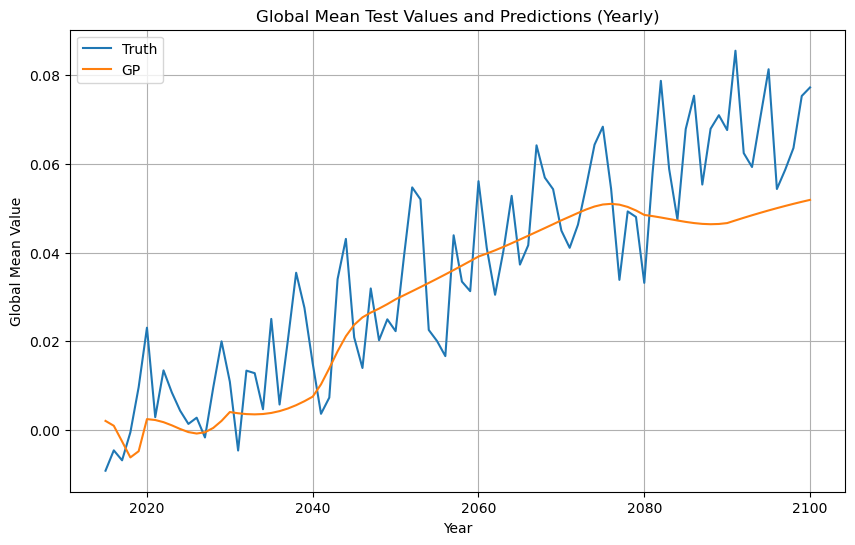

In [37]:
plt.figure(figsize=(10, 6))
global_mean(pr_truth).plot(label="Truth")
global_mean(mean_best).plot(label='GP')
plt.title('Global Mean Test Values and Predictions (Yearly)')
plt.ylabel('Global Mean Value')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

[Text(0.5, 1.0, 'Difference')]

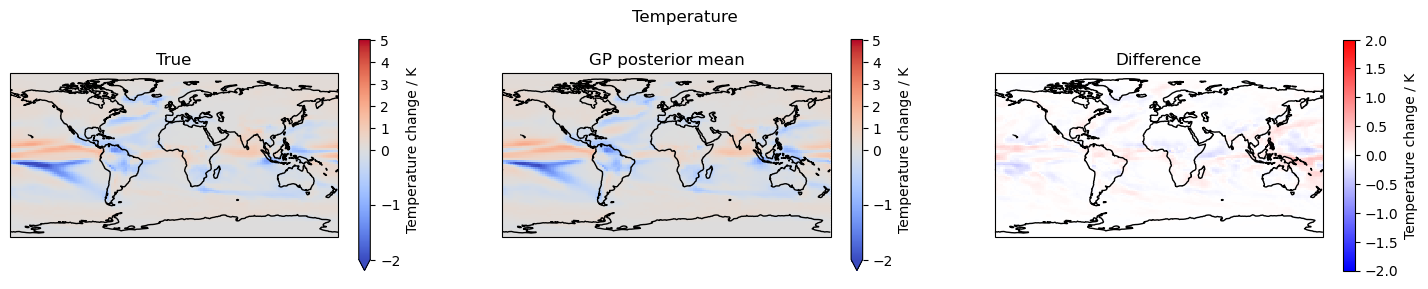

In [38]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
pr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
mean_best.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = pr_truth - mean_best
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [39]:
mean_best.to_netcdf('results/Final-dkl-mean-pr.nc')
std_best.to_netcdf('results/Final-dkl-std-pr.nc')

In [40]:
TNRMSE(pr_truth, mean_best)

4.004

## Best Config

- Kernel = Matern52
- Lr = 0.001
- Output_dim = 24
- Dropout_prob = 0.5
- Dropout = False
- Input_dim = 128
- bnorm = False
- Active Dim = 2
- Activation = Sigmoid